In [1]:
#all imports

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)


In [2]:
#dataset path and activity labels

DATA_ROOT = r"C:\Users\akhil\Downloads\UCI_Dataset"

activity_map = {
    "a01": "sitting", "a02": "standing", "a03": "lying_on_back", "a04": "lying_on_right_side",
    "a05": "ascending_stairs", "a06": "descending_stairs", "a07": "standing_in_elevator_still",
    "a08": "moving_in_elevator", "a09": "walking_in_parking_lot",
    "a10": "walking_on_treadmill_flat_4kmh", "a11": "walking_on_treadmill_incline_4kmh",
    "a12": "running_on_treadmill_8kmh", "a13": "exercising_on_stepper",
    "a14": "exercising_on_cross_trainer", "a15": "cycling_horizontal",
    "a16": "cycling_vertical", "a17": "rowing", "a18": "jumping",
    "a19": "playing_basketball"
}


In [3]:
#feature extraction

def features_extract(segment_array):
    means = np.mean(segment_array, axis=0)
    stds = np.std(segment_array, axis=0)
    mins = np.min(segment_array, axis=0)
    maxs = np.max(segment_array, axis=0)
    return np.concatenate([means, stds, mins, maxs])

def generate_feature_names():
    units = ["T", "RA", "LA", "RL", "LL"]
    sensors = ["xacc","yacc","zacc","xgyro","ygyro","zgyro","xmag","ymag","zmag"]
    stats = ["mean","std","min","max"]
    names = []
    for stat in stats:
        for u in units:
            for s in sensors:
                names.append(f"{u}_{s}_{stat}")
    return names

feature_names = generate_feature_names()
len(feature_names)


180

In [5]:
#load dataset

records = []

for folder_name, activity_id in activity_map.items():
    activity_path = os.path.join(DATA_ROOT, folder_name)
    if not os.path.isdir(activity_path):
        print("Folder not found:", activity_path)
        continue

    for subj in range(1, 9):
        subj_path = os.path.join(activity_path, f"p{subj}")
        if not os.path.isdir(subj_path):
            continue

        for seg in range(1, 61):
            file_name = f"s{seg:02d}.txt"
            file_path = os.path.join(subj_path, file_name)

            if not os.path.isfile(file_path):
                continue

            data_block = np.loadtxt(file_path, delimiter=",")
            if data_block.shape != (125, 45):
                print("Unexpected shape:", file_path, data_block.shape)
                continue

            feat_vals = features_extract(data_block)
            entry = {name: val for name, val in zip(feature_names, feat_vals)}
            entry["activity"] = activity_id
            entry["subject"] = subj
            entry["segment"] = seg

            records.append(entry)

data = pd.DataFrame(records)
print("Final dataset size:", data.shape)
data.head()


Final dataset size: (9120, 183)


,T_xacc_mean,T_yacc_mean,T_zacc_mean,T_xgyro_mean,T_ygyro_mean,T_zgyro_mean,T_xmag_mean,T_ymag_mean,T_zmag_mean,RA_xacc_mean,...,LL_zacc_max,LL_xgyro_max,LL_ygyro_max,LL_zgyro_max,LL_xmag_max,LL_ymag_max,LL_zmag_max,activity,subject,segment
0,7.975714,1.083150,5.606846,0.004897,0.026123,-0.003726,-0.790726,-0.068490,0.135897,0.679134,...,2.6696,0.015853,0.020288,0.013777,0.74238,0.30342,-0.054963,sitting,1,1
1,7.978250,1.140865,5.598922,0.003308,0.022514,-0.003240,-0.791962,-0.070157,0.137123,0.644964,...,2.6707,0.012283,0.020459,0.011976,0.74335,0.30390,-0.054945,sitting,1,2
2,7.970894,1.140962,5.607750,0.001846,0.018806,-0.003486,-0.792875,-0.070723,0.136436,0.608212,...,2.6594,0.010339,0.020252,0.012057,0.74316,0.30423,-0.054711,sitting,1,3
3,7.938412,1.165260,5.648969,0.003788,0.023768,-0.003512,-0.793550,-0.071969,0.131983,0.591138,...,2.7118,0.012145,0.019706,0.019284,0.74313,0.30416,-0.053670,sitting,1,4
4,7.908930,1.187504,5.680980,0.001086,0.012242,-0.002488,-0.793872,-0.072597,0.128345,0.558168,...,2.7047,0.013583,0.019461,0.013865,0.74298,0.30503,-0.053313,sitting,1,5


In [6]:
#defining X and Y

X = data.drop(columns=["activity", "subject", "segment"])
y = data["activity"]

X.shape, y.shape

((9120, 180), (9120,))

In [7]:
#Train/Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
#pipeline for all models

svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("clf", SVC())
])

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("clf", KNeighborsClassifier())
])

lda_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis())
])

dt_pipe = Pipeline([
    ("clf", DecisionTreeClassifier(random_state=42))
])


In [9]:
#hyperparameters

svm_params = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.001],
    "clf__kernel": ["rbf"]
}

knn_params = {
    "clf__n_neighbors": [3, 5, 7, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "manhattan"]
}

lda_params = {
    "clf__solver": ["svd", "lsqr"]
}

dt_params = {
    "clf__max_depth": [None, 10, 20, 40],
    "clf__criterion": ["gini", "entropy"]
}


In [10]:
#training function

def train_model(name, pipeline, param_grid):
    print(f"\n {name} ")

    gs = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        n_jobs=-1,
        scoring="f1_macro"
    )
    gs.fit(X_train, y_train)

    preds = gs.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")

    print("Best params:", gs.best_params_)
    print(f"Accuracy: {acc:.5f}")
    print(f"Macro F1: {f1:.5f}")
    print("\nReport:\n", classification_report(y_test, preds))

    # Confusion Matrix
    labels = sorted(y.unique())
    cm = confusion_matrix(y_test, preds, labels=labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=False, cmap="Greens",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    return gs, acc, f1



 SVM 
Best params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Accuracy: 0.99342
Macro F1: 0.99342

Report:
                                    precision    recall  f1-score   support

                 ascending_stairs       1.00      1.00      1.00        96
               cycling_horizontal       1.00      1.00      1.00        96
                 cycling_vertical       1.00      1.00      1.00        96
                descending_stairs       1.00      1.00      1.00        96
      exercising_on_cross_trainer       1.00      0.99      0.99        96
            exercising_on_stepper       0.99      1.00      0.99        96
                          jumping       1.00      1.00      1.00        96
                    lying_on_back       1.00      0.99      0.99        96
              lying_on_right_side       1.00      1.00      1.00        96
               moving_in_elevator       0.99      0.93      0.96        96
               playing_basketball       0.98    

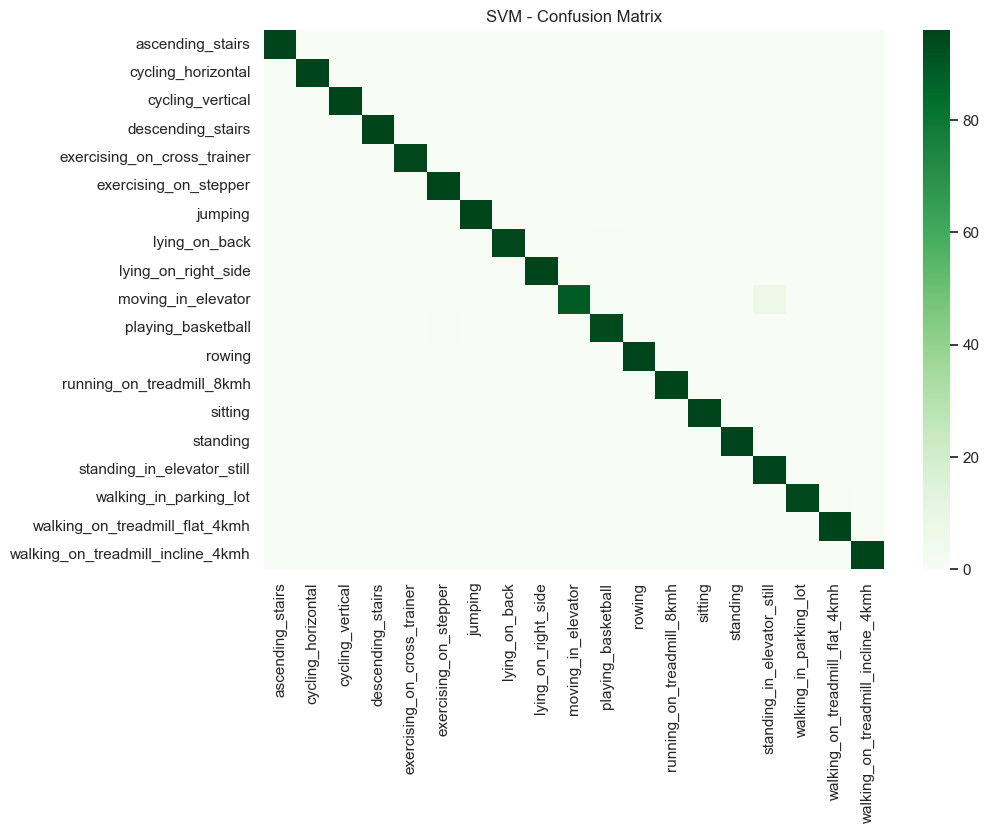


 KNN 


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [0.98331476 0.98346522 0.98000467 0.98186722 0.97919373 0.9809415
 0.97540466 0.9779266         nan 0.98285192        nan 0.98234945
        nan 0.97974348        nan 0.9766321 ]
  warnings.warn(


Best params: {'clf__metric': 'euclidean', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Accuracy: 0.98904
Macro F1: 0.98895

Report:
                                    precision    recall  f1-score   support

                 ascending_stairs       1.00      1.00      1.00        96
               cycling_horizontal       1.00      1.00      1.00        96
                 cycling_vertical       1.00      1.00      1.00        96
                descending_stairs       0.99      1.00      0.99        96
      exercising_on_cross_trainer       0.99      1.00      0.99        96
            exercising_on_stepper       0.99      1.00      0.99        96
                          jumping       1.00      1.00      1.00        96
                    lying_on_back       1.00      0.99      0.99        96
              lying_on_right_side       1.00      1.00      1.00        96
               moving_in_elevator       0.97      0.86      0.91        96
               playing_basketball  

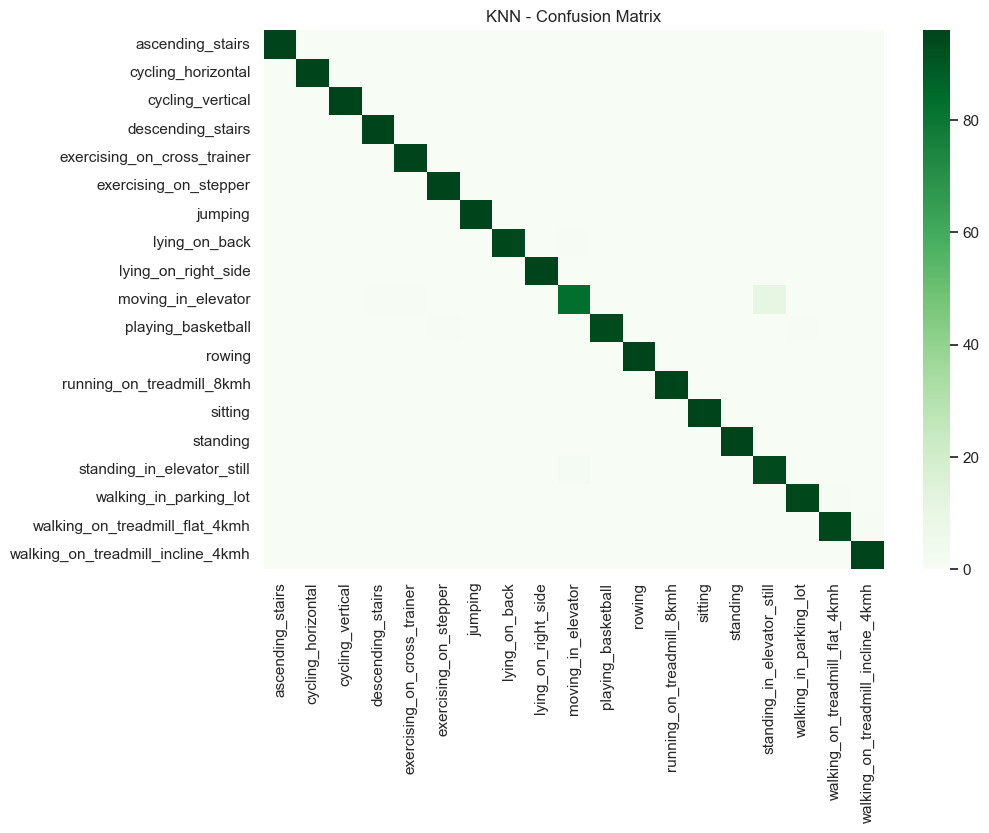


 LDA 
Best params: {'clf__solver': 'svd'}
Accuracy: 0.98629
Macro F1: 0.98609

Report:
                                    precision    recall  f1-score   support

                 ascending_stairs       1.00      1.00      1.00        96
               cycling_horizontal       1.00      1.00      1.00        96
                 cycling_vertical       1.00      1.00      1.00        96
                descending_stairs       0.98      1.00      0.99        96
      exercising_on_cross_trainer       1.00      1.00      1.00        96
            exercising_on_stepper       1.00      1.00      1.00        96
                          jumping       1.00      1.00      1.00        96
                    lying_on_back       1.00      1.00      1.00        96
              lying_on_right_side       1.00      1.00      1.00        96
               moving_in_elevator       0.99      0.80      0.89        96
               playing_basketball       1.00      0.98      0.99        96
          

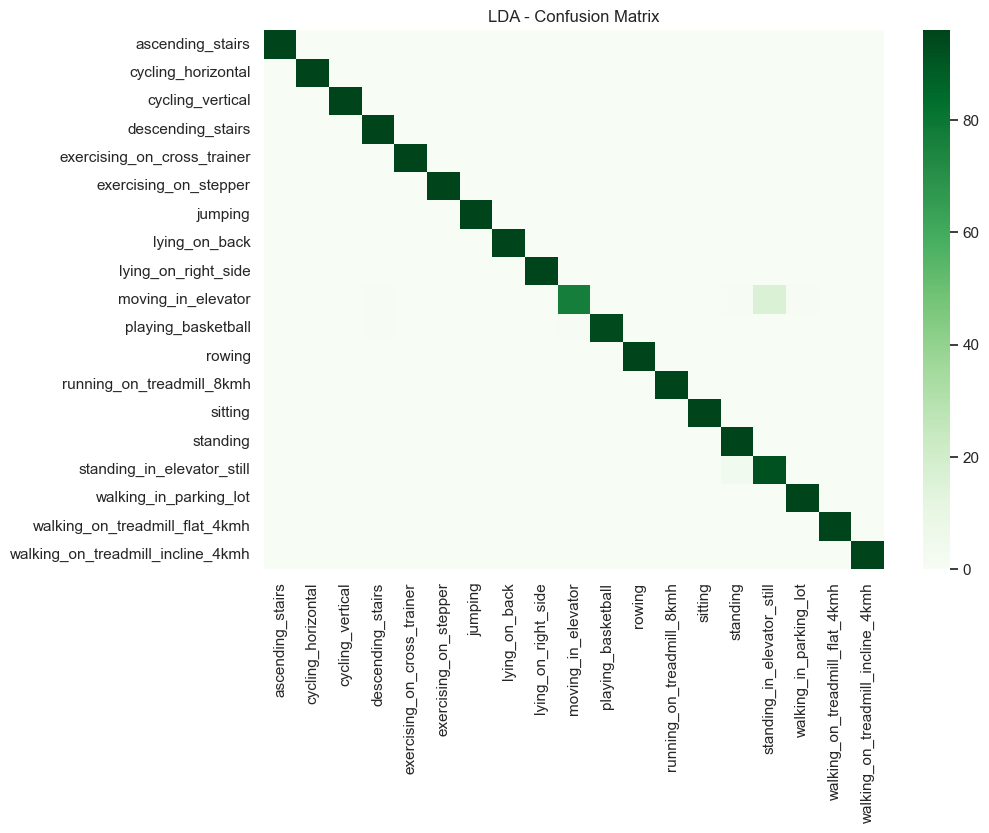


 Decision Tree 
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None}
Accuracy: 0.98081
Macro F1: 0.98065

Report:
                                    precision    recall  f1-score   support

                 ascending_stairs       0.96      1.00      0.98        96
               cycling_horizontal       0.99      1.00      0.99        96
                 cycling_vertical       1.00      1.00      1.00        96
                descending_stairs       0.99      0.98      0.98        96
      exercising_on_cross_trainer       0.98      0.98      0.98        96
            exercising_on_stepper       0.98      0.96      0.97        96
                          jumping       1.00      0.98      0.99        96
                    lying_on_back       1.00      1.00      1.00        96
              lying_on_right_side       1.00      1.00      1.00        96
               moving_in_elevator       0.93      0.86      0.90        96
               playing_basketball       0.95   

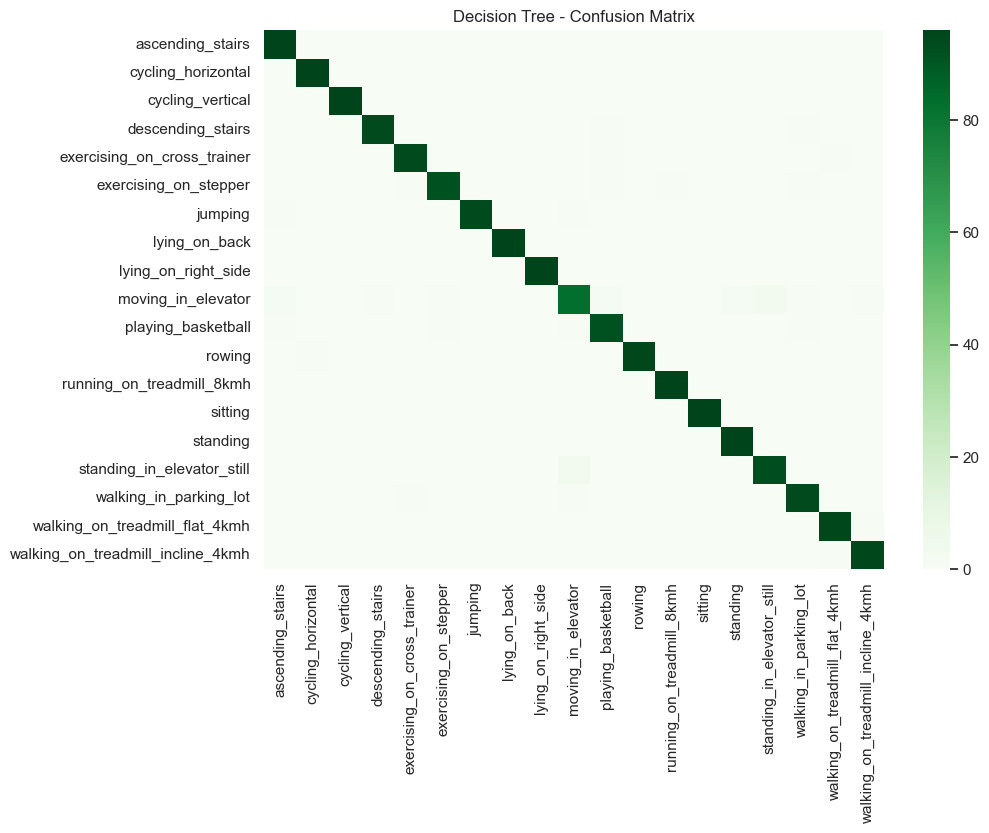


 Model Performance Summary 
SVM:            0.993421052631579 0.9934163438946456
KNN:            0.9890350877192983 0.9889521397554948
LDA:            0.9862938596491229 0.9860852949277866
Decision Tree:  0.9808114035087719 0.9806546375898596


In [11]:
#train all models

svm_best, svm_acc, svm_f1 = train_model("SVM", svm_pipe, svm_params)
knn_best, knn_acc, knn_f1 = train_model("KNN", knn_pipe, knn_params)
lda_best, lda_acc, lda_f1 = train_model("LDA", lda_pipe, lda_params)
dt_best, dt_acc, dt_f1   = train_model("Decision Tree", dt_pipe, dt_params)

print("\n Model Performance Summary ")
print("SVM:           ", svm_acc, svm_f1)
print("KNN:           ", knn_acc, knn_f1)
print("LDA:           ", lda_acc, lda_f1)
print("Decision Tree: ", dt_acc, dt_f1)


In [12]:
#comparison table

comparison_table = pd.DataFrame({
    "Model": ["SVM", "KNN", "LDA", "Decision Tree"],
    "Accuracy": [svm_acc, knn_acc, lda_acc, dt_acc],
    "Macro F1": [svm_f1, knn_f1, lda_f1, dt_f1]
})

comparison_table


,Model,Accuracy,Macro F1
0,SVM,0.993421,0.993416
1,KNN,0.989035,0.988952
2,LDA,0.986294,0.986085
3,Decision Tree,0.980811,0.980655


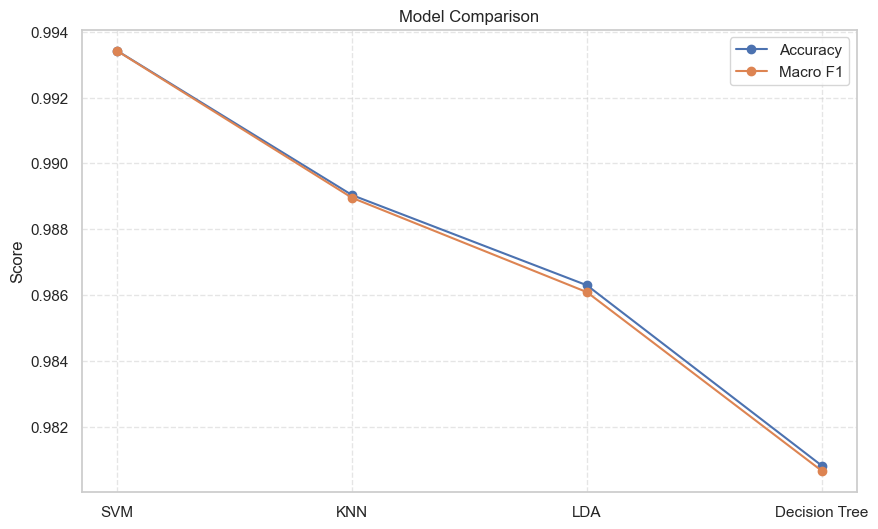

In [13]:
#model comparison plot

plt.figure(figsize=(10,6))
plt.plot(comparison_table["Model"], comparison_table["Accuracy"], marker='o', label='Accuracy')
plt.plot(comparison_table["Model"], comparison_table["Macro F1"], marker='o', label='Macro F1')
plt.title("Model Comparison")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()
